**NLP untuk Multiclass Kategori Berita BBC**

**Unduh Dataset Memakai Kaggle**

In [1]:
#Install Kaggle Package
!pip install -q kaggle

In [2]:
# upload API kaggle.json
from google.colab import files
files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"heyitsmutee","key":"667512aa901b5745ff966a80ce852dc3"}'}

In [3]:
# Buat directory and ubah ijin
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [76]:
# download dataset, paste 'copy api command' dari kaggle dataset
!kaggle datasets download -d hgultekin/bbcnewsarchive

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 59.5MB/s]


In [79]:
# Unzip
!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchive

Archive:  bbcnewsarchive.zip
  inflating: bbcnewsarchive/bbc-news-data.csv  
bbc-news-data.csv


**Load Dataset**

In [80]:
# Import pandas
import pandas as pd

In [83]:
#Load dataset
df = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')
df.head(10)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


In [84]:
# data columns
df.columns

Index(['category', 'filename', 'title', 'content'], dtype='object')

In [85]:
df.shape

(2225, 4)

In [86]:
df.info

<bound method DataFrame.info of       category  ...                                            content
0     business  ...   Quarterly profits at US media giant TimeWarne...
1     business  ...   The dollar has hit its highest level against ...
2     business  ...   The owners of embattled Russian oil giant Yuk...
3     business  ...   British Airways has blamed high fuel prices f...
4     business  ...   Shares in UK drinks and food firm Allied Dome...
...        ...  ...                                                ...
2220      tech  ...   BT is introducing two initiatives to help bea...
2221      tech  ...   Computer users across the world continue to i...
2222      tech  ...   A new European directive could put software w...
2223      tech  ...   The man making sure US computer networks are ...
2224      tech  ...   Online role playing games are time-consuming,...

[2225 rows x 4 columns]>

In [87]:
# Lihat kolom kategori
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [88]:
df_new = df.drop(columns=['filename'])
df_new

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


**Data Cleaning**

In [89]:
# import and download package
import nltk, os, re, string

from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [91]:
p_test = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')
p_test.content=p_test.content.astype(str)

In [92]:
# lower-case all characters
df_new.title = df_new.title.apply(lambda x: x.lower())
df_new.content = df_new.content.apply(lambda x: x.lower())

# removing functuation
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df_new.title = df_new.title.apply(lambda x: cleaner(x))
    df_new.content = df_new.content.apply(lambda x: lem(x))

## lematization
lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df_new.title = df_new.title.apply(lambda x: lem(x))
    df_new.content = df_new.content.apply(lambda x: lem(x))

# removing number
def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df_new['title'].apply(rem_numbers)
    df_new['content'].apply(rem_numbers)

# removing stopword
st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df_new.title = df_new.title.apply(lambda x: stopword(x))
    df_new.content = df_new.content.apply(lambda x: lem(x))

In [93]:
# view data after cleansing
df_new.head(10)

,category,title,content
0,business,ad sales boost time warner profit,quarterly profits at us media giant timewarne...
1,business,dollar gains on greenspan speech,the dollar has hit its highest level against ...
2,business,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...
3,business,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...
4,business,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...
5,business,japan narrowly escapes recession,japan's economy teetered on the brink of a te...
6,business,jobs growth still slow in the us,the us created fewer jobs than expected in ja...
7,business,india calls for fair trade rules,"india, which attends the g7 meeting of seven ..."
8,business,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...
9,business,court rejects $280bn tobacco case,a us government claim accusing the country's ...


**Model and Plot**

In [94]:
# data category one-hot-encoding
category = pd.get_dummies(df_new.category)
df_new_cat = pd.concat([df_new, category], axis=1)
df_new_cat = df_new_cat.drop(columns='category')
df_new_cat.head(10)

,title,content,business,entertainment,politics,sport,tech
0,ad sales boost time warner profit,quarterly profits at us media giant timewarne...,1,0,0,0,0
1,dollar gains on greenspan speech,the dollar has hit its highest level against ...,1,0,0,0,0
2,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...,1,0,0,0,0
3,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...,1,0,0,0,0
4,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...,1,0,0,0,0
5,japan narrowly escapes recession,japan's economy teetered on the brink of a te...,1,0,0,0,0
6,jobs growth still slow in the us,the us created fewer jobs than expected in ja...,1,0,0,0,0
7,india calls for fair trade rules,"india, which attends the g7 meeting of seven ...",1,0,0,0,0
8,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...,1,0,0,0,0
9,court rejects $280bn tobacco case,a us government claim accusing the country's ...,1,0,0,0,0


In [96]:
# change dataframe value to numpy array
news = df_new_cat['title'].values + '' + df_new_cat['content'].values
label = df_new_cat[['business','tech', 'sport', 'politics', 'entertainment']].values

In [97]:
# view news array
news

array(['ad sales boost time warner profit quarterly profits at us media giant timewarner jumped 76% to $1.13bn (£600m) for the three months to december, from $639m year-earlier.  the firm, which is now one of the biggest investors in google, benefited from sales of high-speed internet connections and higher advert sales. timewarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. its profits were buoyed by one-off gains which offset a profit dip at warner bros, and less users for aol.  time warner said on friday that it now owns 8% of search-engine google. but its own internet business, aol, had has mixed fortunes. it lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. however, the company said aol\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. it hopes to increase subscribers by offering the online service free to timewarner internet customers and will try to sig

In [98]:
# view label array
label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [99]:
# Split data into training and validation
from sklearn.model_selection import train_test_split
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size=0.2, shuffle=True)

In [100]:
# tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(news_train) 
tokenizer.fit_on_texts(news_test)
 
sekuens_train = tokenizer.texts_to_sequences(news_train)
sekuens_test = tokenizer.texts_to_sequences(news_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [102]:
# model
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 645       
Total params: 435,973
Trainable params: 435,973
Non-trainable params: 0
_________________________________________________________________


In [103]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.8 and logs.get('val_accuracy')>0.8):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 80%!")
callbacks = myCallback()

In [104]:
# model fit
history = model.fit(padded_train, label_train, epochs=10, 
                    validation_data=(padded_test, label_test), verbose=1, callbacks=[callbacks], validation_steps=30)

Epoch 1/10
56/56 [==============================] - 226s 4s/step - loss: 0.5314 - accuracy: 0.2191 - val_loss: 0.5063 - val_accuracy: 0.2112
Epoch 2/10
56/56 [==============================] - 223s 4s/step - loss: 0.5074 - accuracy: 0.2449 - val_loss: 0.5101 - val_accuracy: 0.2292
Epoch 3/10
56/56 [==============================] - 223s 4s/step - loss: 0.4630 - accuracy: 0.3674 - val_loss: 0.8527 - val_accuracy: 0.2292
Epoch 4/10
56/56 [==============================] - 225s 4s/step - loss: 0.3922 - accuracy: 0.5191 - val_loss: 0.3649 - val_accuracy: 0.5146
Epoch 5/10
56/56 [==============================] - 224s 4s/step - loss: 0.2978 - accuracy: 0.7051 - val_loss: 0.2836 - val_accuracy: 0.7056
Epoch 6/10
56/56 [==============================] - 223s 4s/step - loss: 0.1984 - accuracy: 0.8438 - val_loss: 0.1650 - val_accuracy: 0.8584

The accuracy of the training set and the validation set has reached > 80%!


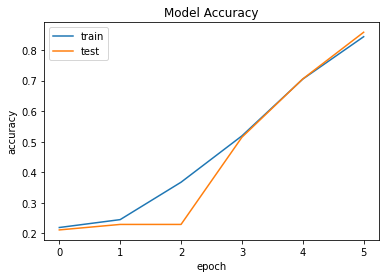

In [105]:
# plot of accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

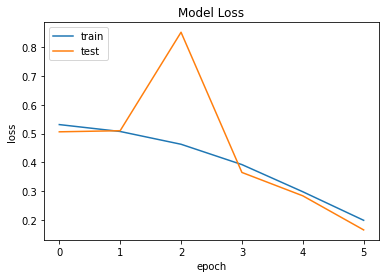

In [106]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()